In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [1]:
DATA_PATH = '/content/drive/MyDrive/AI_camp_data/CP2/scratch_final/'
MODEL_PATH = '/content/drive/MyDrive/AI_camp_data/CP2/model_results/'

In [3]:
!git clone https://github.com/NVIDIA/apex

Cloning into 'apex'...
remote: Enumerating objects: 10063, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 10063 (delta 87), reused 124 (delta 55), pack-reused 9884
Receiving objects: 100% (10063/10063), 14.94 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (6892/6892), done.


In [4]:
cd apex

/content/apex


In [ ]:
!python setup.py install # 이거 하고 런타임 다시 시작

In [3]:
#압축 풀기
import shutil
shutil.unpack_archive(f'{DATA_PATH}train_final.zip','./data', 'zip') # 사용할 데이터
shutil.unpack_archive(f'{DATA_PATH}unet_module_final.zip','./', 'zip')

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


import torch
from torch.utils.data import Dataset

import torch.optim as optim
from pytorchtools import EarlyStopping
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from DiceLoss import DiceLoss
from ScratchDataset import ScratchDataset
from transformers import ToTensor, Normalization, RandomFlip
from UNet3Plus import UNet3Plus
from UNet import UNet
from apex import amp

In [3]:
# 압축 푼 곳에서 사용할 데이터 이름들
DATA_PATH2 = './data'
dir_save_train = os.path.join(DATA_PATH2, 'train_final')
dir_save_val = os.path.join(DATA_PATH2, 'val_final')

# 1. 데이터 불러오기

(256, 256, 1)
(256, 256, 1)


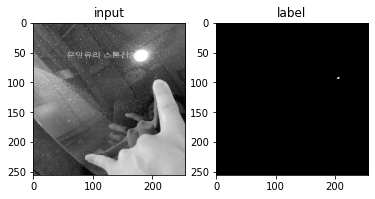

13534 2843


In [7]:
train = ScratchDataset(dir_save_train, data_type = 'train')
val = ScratchDataset(dir_save_val, data_type = 'val')

d = train[0] # 0번째 이미지 불러오기
input = d['input']
label = d['label']

print(input.shape)
print(label.shape)

# 불러온 이미지 시각화
plt.subplot(122)
plt.imshow(label.reshape(256,256), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(256,256), cmap='gray')
plt.title('input')

plt.show()

print(len(train), len(val))

# 2. Transform

- ToTensor : numpy에서 tensor로 데이터 type을 변경

- Normalization : 데이터 정규화

- RandomFlip : 랜덤 좌우 및 상하 반전

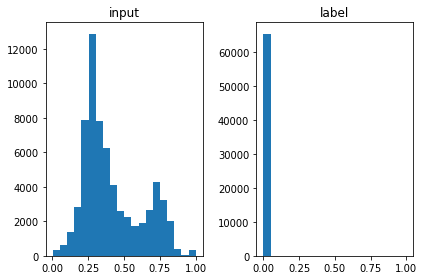

In [9]:
# 트랜스폼
transform = transforms.Compose([Normalization(mean = 0.5, std = 0.5), RandomFlip(), ToTensor()])
dataset_train = ScratchDataset(data_dir = dir_save_train, transform = transform, data_type = 'train')

d = train[0] # 한 이미지 불러오기
input = d['input']
label = d['label']

# 이미지 시각화
plt.subplot(122)
plt.hist(np.array(label).flatten(), bins=20) # 1이 너무 적어서 그렇지 1도 있긴 있음.
plt.title('label')

plt.subplot(121)
plt.hist(np.array(input).flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

In [15]:
print(pd.Series(np.array(label).flatten()).value_counts(normalize = True)) # 위의 이미지는 스톤칩이라는 아주 작은 흠집이기 때문에 배경인 0 class의 비율이 압도적으로 많다.
print(np.unique(np.array(label))) # label 데이터가 0과 1로 이루어져 있다는 것을 확인할 수 있다.

0.0    0.999847
1.0    0.000153
dtype: float64
[0. 1.]


# 3. 모델 학습
U-Net이나 U-Net3Plus 모델 학습 가능

In [16]:
# 하이퍼 파라미터 조정
lr = 3.2500e-05
batch_size = 4
num_epoch = 25
patience, verbose = 15, 1 
counter = 0

In [18]:
# 훈련을 위한 Transform과 DataLoader
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = ScratchDataset(dir_save_train, transform=transform, data_type = 'train')
loader_train = DataLoader(dataset_train, batch_size=batch_size)

dataset_val = ScratchDataset(dir_save_val, transform=transform, data_type = 'val')
loader_val = DataLoader(dataset_val, batch_size=batch_size)

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)
#net = UNet3Plus().to(device)

# 손실함수 정의하기
fn_loss = DiceLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)
model, optim = amp.initialize(net, optim, opt_level="O1") # 이거 쓰는게 optimizer가 훨씬 빠름.

# optimizer와 스케줄러 수정
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=3, T_mult = 1, eta_min=0.00001, verbose = True)
#T_0은 첫 주기의 길이를 의미하고, 이후에는 주기가 T_mult만큼 곱해진다. 
#학습률이 계속 내려가는게 아니라 진동하는게 더 안정적이라고 해서 cosine annealing warm restarts 사용
#Warm Restart는 learning rate의 감소 후 급격하게 증가하게 함으로써 local optima에 빠지는 것과 overfitting을 방지


# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

# batch 갯수
num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
# GPU로 되어있는 텐서를 CPU로 변환해줘야지만 이미지 출력 가능
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)

# nomalization 되어있는 것을 원래대로 돌리기
fn_denorm = lambda x, mean, std: (x * std) + mean

# 모델의 출력값이 0.5보다 크면 스크래치(1 class)로 작으면 배경(0 class)으로
fn_class = lambda x: 1.0 * (x > 0.5)


# 네트워크 학습시키기
st_epoch = 0

val_loss_list = [np.Inf]
train_loss_list = []

for epoch in tqdm(range(st_epoch + 1, num_epoch + 1)):
        if min(val_loss_list) < val_loss_list[-1]:
            counter += 1
        early_stopping = EarlyStopping(patience=patience, verbose=verbose, val_loss_min = min(val_loss_list),
                                      best_score = min(val_loss_list), counter = counter, path = f'{MODEL_PATH}best_model.pt') # Best model을 저장
        net.train()
        loss_arr = []

        with tqdm(total=int(num_batch_train), desc=f'Epoch {epoch}/{num_epoch + 11}', unit='batch') as pbar:
            for batch, data in enumerate(loader_train, 1):
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # backward pass
                optim.zero_grad()

                loss = fn_loss(output, label)
                # loss.backward()
                with amp.scale_loss(loss, optim) as scaled_loss:
                    scaled_loss.backward()

                optim.step()

                # 손실함수 계산
                loss_arr += [loss.item()]
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                pbar.update(1) # 배치가 끝날 때마다 pbar 업데이트
            train_loss_list.append(np.mean(loss_arr))
            print(f'{epoch} Epoch train loss',np.mean(loss_arr))
#            scheduler.step() # 스케줄러의 학습률 조정

        with torch.no_grad(): # no_grad는, 검증이나 테스트 데이터에서는 경사하강법을 적용시켜 학습시킬 필요가 없으므로
                                #경사를 계산하는 파트를 비활성화 하는 것이다. 따라서 연산 속도가 빠르고, 메모리가 줄어든다.
            net.eval()
            loss_arr = []

            with tqdm(total=int(num_batch_val), desc=f'Epoch {epoch}/{num_epoch + 27}', unit='batch') as pbar:
                for batch, data in enumerate(loader_val, 1):
                    # forward pass
                    label = data['label'].to(device)
                    input = data['input'].to(device)

                    output = net(input)

                    loss = fn_loss(output, label)

                    loss_arr += [loss.item()]
                    pbar.set_postfix(**{'loss (batch)': loss.item()})
                
                    pbar.update(1)

                val_loss_list.append(np.mean(loss_arr))

        early_stopping(np.mean(loss_arr), net)
        
        if early_stopping.early_stop: # 과적합 방지를 위한 Early Stopping
            print("Early stopping")
            break

In [ ]:
print(len(val_loss_list))
print(min(val_loss_list)) # 검증 데이터 최소 손실

In [ ]:
# 학습과 검증 데이터의 에포크당 손실이 어떻게 줄어드는지 시각화
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.show()

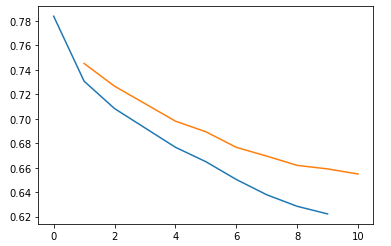

# 4. 결과 확인

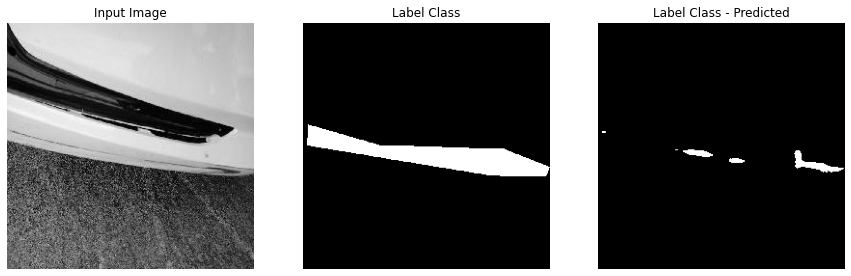

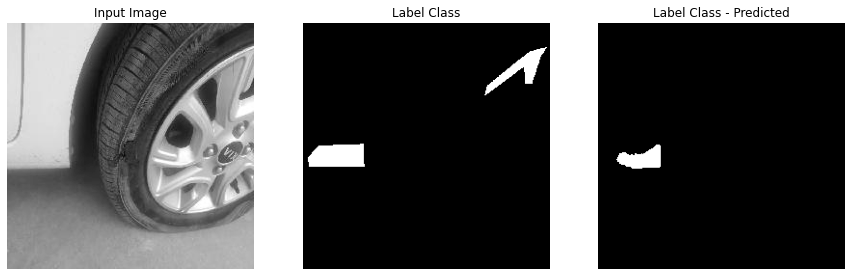

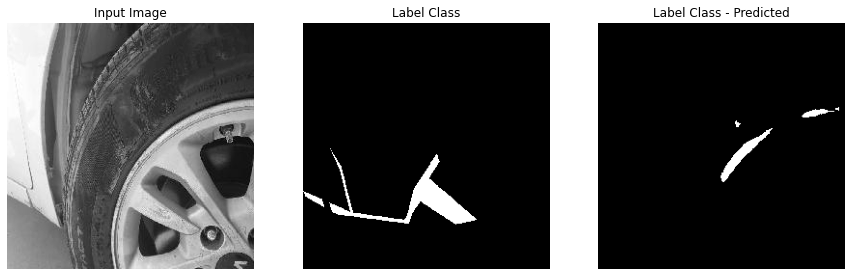

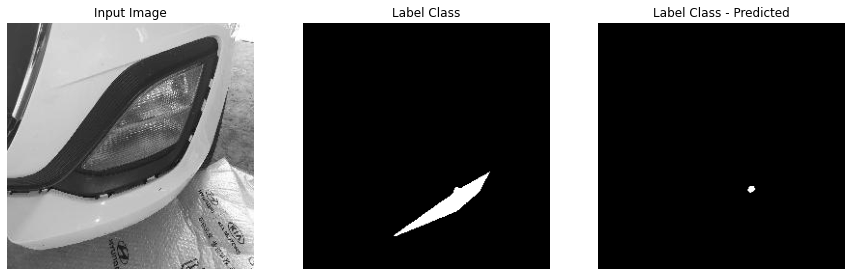

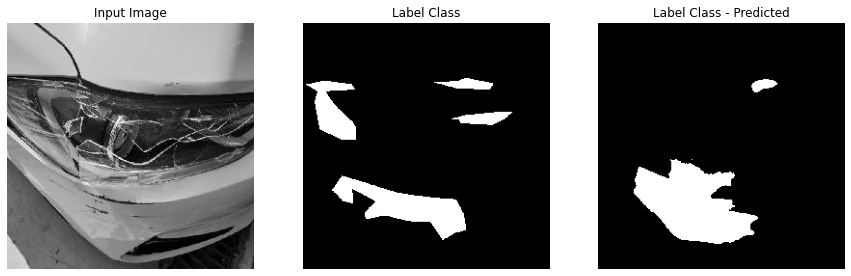

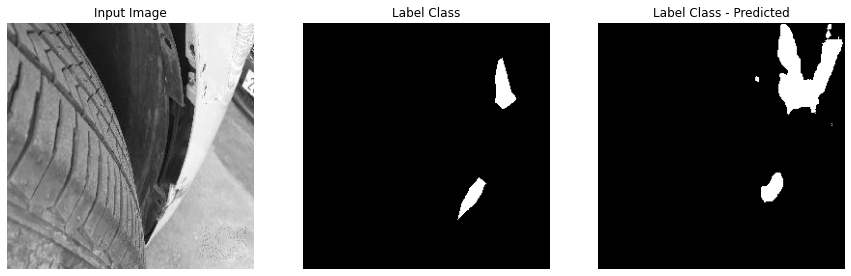

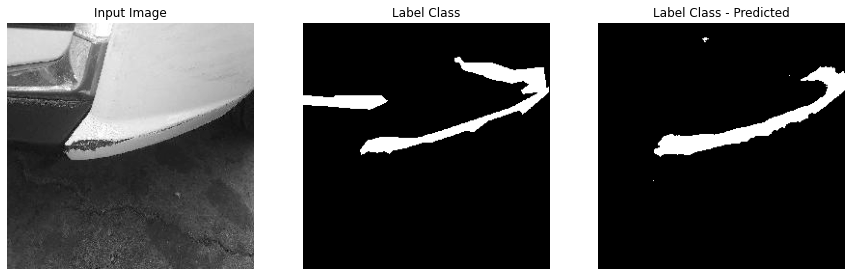

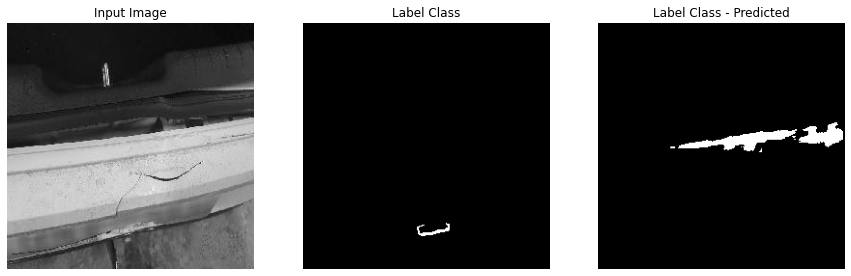

IoU Score:  0.21073900210039284
AVERAGE TEST: BATCH 0711 / 0711 | LOSS 0.6039


In [13]:
model = UNet().to(device)
# model = UNet3Plus().to(device)
model.load_state_dict(torch.load(f'{MODEL_PATH}best_model.pt'))
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = ScratchDataset(dir_save_val, transform=transform, data_type = 'val')
loader_test = DataLoader(dataset_test, batch_size=batch_size)
# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

iou_scores = []

# 결과 디렉토리 생성하기
with torch.no_grad():
      model.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = model(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          # 텐서를 numpy로 변환. 이미지로 그리기 위해서
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 그리기
          for j in range(label.shape[0]):
                input_image = input[j].squeeze()
                label_class = label[j].squeeze()
                label_class_predicted = output[j].squeeze()

                #  IOU score
                intersection = np.logical_and(label_class, label_class_predicted)
                union = np.logical_or(label_class, label_class_predicted)
                iou_score = np.sum(intersection) / np.sum(union)
                iou_scores.append(iou_score)
                
                if j % 3 == 0 and j != 0 and batch % 71 == 0 and batch > 200:
                  fig, axes = plt.subplots(1, 3, figsize=(3*5, batch_size*5))
                  axes[0].imshow(input_image, cmap = 'gray')
                  axes[0].set_title("Input Image")
                  axes[1].imshow(label_class, cmap = 'gray')
                  axes[1].set_title("Label Class")
                  axes[2].imshow(label_class_predicted, cmap = 'gray')
                  axes[2].set_title("Label Class - Predicted")
                  axes[0].axis('off')
                  axes[1].axis('off')
                  axes[2].axis('off')
                  plt.show()
print("IoU Score: ", np.nansum(iou_scores) / len(iou_scores))

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))  